In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for making figures
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from timeit import default_timer as timer  #for checking run time
from datetime import timedelta
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import callbacks
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras import layers

In [2]:
df = pd.read_csv("The-Office-Lines-V2.csv")
print(f"dataset has {df.columns.shape[0]} columns \ndataset has {df.shape[0]} rows")
df.head(3)

dataset has 6 columns 
dataset has 54167 rows


,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...


In [3]:
df.isnull().sum()  #no missing value

season     0
episode    0
title      0
scene      0
speaker    0
line       0
dtype: int64

In [4]:
df.dtypes # we have 3 integer/numeric and 3 object columns

season      int64
episode     int64
title      object
scene       int64
speaker    object
line       object
dtype: object

In [5]:
dicct ={}
for i in range(5):
    dicct[df.iloc[:,i].name] = df.iloc[:,i].unique()
dicct.keys()

dict_keys(['season', 'episode', 'title', 'scene', 'speaker'])

In [6]:
len(dicct["speaker"])

777

In [21]:
mostchar=df.groupby(by="speaker",sort=False).agg({"speaker":"count"}).rename_axis("index").sort_values(by="speaker",ascending=False)[:5].index
mostchar.tolist()

['Michael', 'Dwight', 'Jim', 'Pam', 'Andy']

In [22]:
df2=df[df.speaker.isin(mostchar)]

In [23]:
bım=lambda x:len(x.split())  #finding line lengtg
df2["line"].apply(bım).sort_values(ascending =False).head()  #length of lines

13117    232
3385     164
34647    163
12191    159
28356    157
Name: line, dtype: int64

In [24]:
df3 = df2.copy()
df3["linecount"] = df2["line"].apply(bım)
df4=df3[(df3["linecount"]<=20) & (df3["linecount"]>1)]
df4.head(10) #an alternative approach would be this, this performs better with Multinominal NB but it does not affect NN

,season,episode,title,scene,speaker,line,linecount
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,14
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",9
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,14
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",8
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",10
7,1,1,Pilot,3,Pam,Well. I don't know.,4
8,1,1,Pilot,3,Michael,"If you think she's cute now, you should have s...",16
10,1,1,Pilot,3,Michael,Any messages?,2
11,1,1,Pilot,3,Pam,"Uh, yeah. Just a fax.",5
13,1,1,Pilot,3,Pam,You haven't told me.,4


(0.0, 50.0)

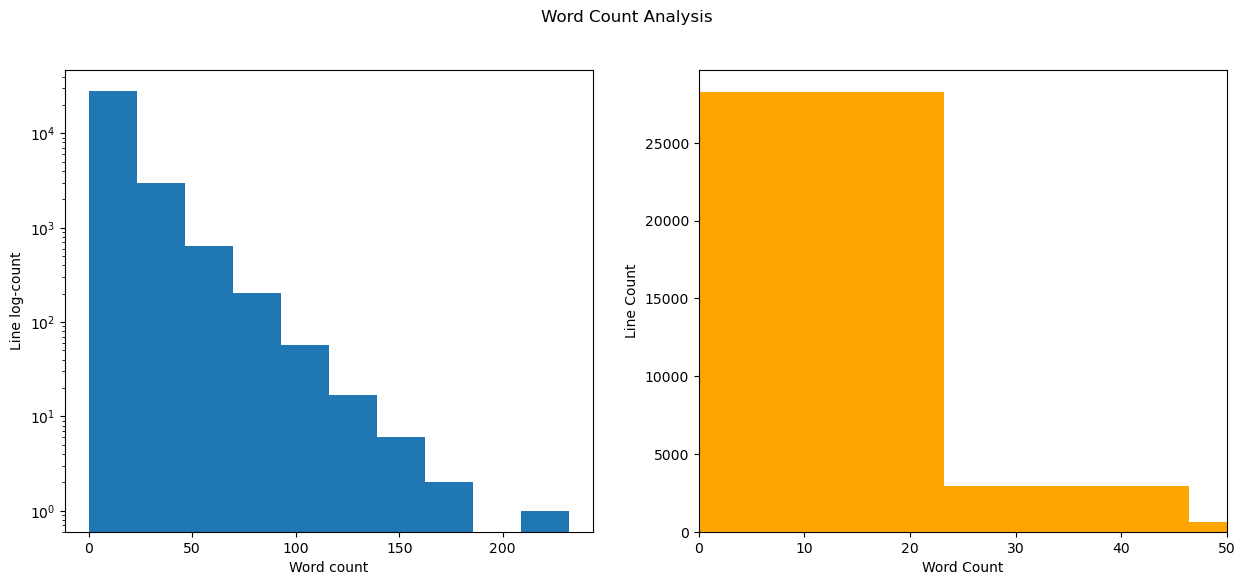

In [25]:
word_count=df2["line"].apply(bım).sort_values(ascending =False)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
fig.suptitle('Word Count Analysis')

ax1.hist(word_count,log=True)
ax1.set_xlabel('Word count')
ax1.set_ylabel("Line log-count")

ax2.hist(word_count,color="orange")
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Line Count')
ax2.set_xlim(0,50)


In [37]:
x1 = df2.line
x1
y1 = df2.speaker
y1

0        Michael
1            Jim
2        Michael
3            Jim
4        Michael
          ...   
54143       Andy
54147        Jim
54149        Jim
54165        Jim
54166        Pam
Name: speaker, Length: 32166, dtype: object

In [38]:
class sentimentanalysis(object):
    
    def fit_str(self,stringg:str):   #In the end i have learned that column vectorizer figures this one out but for using strict this needed
        stringg = stringg.lower() 
        self.arr= np.array(" ".join(re.split("\s+", stringg, flags=re.UNICODE)).split())
        return self.arr
    
    def fit_array(self,array:np.array): #this also not very necessary, at least last part is called at Predict
        length = array.size
        for a in range(length):
            array[a] = array[a].lower()
            array[a] =" ".join(re.split("\s+", array[a], flags=re.UNICODE))
        array = self.cv.transform(array)
        return array
    
    def processDataFrame(self,data,label1:str,label2:str): # If you want to train model and you only have a dataframe
        

        data2=data.copy()
        data2[label1+" processed"] =data2[label1].apply(lambda x: " ".join(self.fit_str(x)))
        self.data2 = data2
        self.label1 = label1
        self.label2 = label2
        self.x=np.array(self.data2[self.label1])
        self.y=np.array(self.data2[self.label2])
        
    def model_train_test_build(self,y = None,x=None): #if you have x and y just use this one
        if x is None:
            x = self.x
        else:
            x = x
        if y is None:
            y = self.y
        else:
            y  = y
            
        self.cv = CountVectorizer()
        self.clf = MultinomialNB()
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3 )
        X_train =self.cv.fit_transform(X_train)
        X_test = self.cv.transform(X_test)
        self.clf.fit(X_train,y_train)
        pred = self.clf.predict(X_test)
        if np.unique(y).size == 2:
            
            self.matrix=confusion_matrix(y_test,pred)
            sns.set(font_scale=1.5)
            fig, ax = plt.subplots(figsize=(3, 3))
            ax = sns.heatmap(self.matrix,
                     annot=True,
                     cbar=False)
            plt.xlabel("Predicted label")
            plt.ylabel("True label")
        print("Accuracy : ",sum(pred==y_test)/y_test.size)
        
    def Predict(self,inp=None):  #After all steps use this, you may just give an string or a array of strings
    
        if inp is None:
            inp = str(input())

        
        if type(inp) == str:
            inp = np.array([" ".join((self.fit_str(inp)))])
            inp = self.cv.transform(inp)
            return self.clf.predict(inp)
        elif type(inp)==np.ndarray:
            inp  = self.fit_array(inp)
            return self.clf.predict(inp)
        else:
            print("Please give array or string")

In [39]:
dtc = sentimentanalysis()

In [45]:
dtc.processDataFrame(df2,"line","speaker")

dtc.model_train_test_build()


Accuracy :  0.3861139896373057


In [46]:
np.unique(y1.values,return_counts=True)

(array(['Andy', 'Dwight', 'Jim', 'Michael', 'Pam'], dtype=object),
 array([ 3658,  6707,  6156, 10712,  4933], dtype=int64))

In [47]:
sum(dtc.Predict(x1.values) == y1.values)/y1.values.size

0.48268357893427843

In [48]:
data=np.unique(dtc.Predict(x1.values),return_counts=True)

In [52]:
dfforiginal

,speaker
index,
Michael,10712
Dwight,6707
Jim,6156
Pam,4933
Andy,3658
Angela,1529
Kevin,1516
Erin,1401
Oscar,1320


In [53]:
dff=pd.DataFrame(data).T
dff=dff.set_index(0).rename_axis("index").rename(columns={1:"model's"})
dfforiginal=df2.groupby(by="speaker",sort=False).agg({"speaker":"count"}).rename_axis("index").sort_values(by="speaker",ascending=False)[:10]

In [54]:
df_merged= dfforiginal.join(dff).rename(columns={"speaker":"original"}).reset_index()
df_merged
#here comes to melting
df_last = df_merged.melt(id_vars=["index"],var_name="original_or_model",value_name="line_count")
df_last
df_merged

,index,original,model's
0,Michael,10712,22194
1,Dwight,6707,3747
2,Jim,6156,3642
3,Pam,4933,1526
4,Andy,3658,1057


Text(0.5, 0, 'Characters')

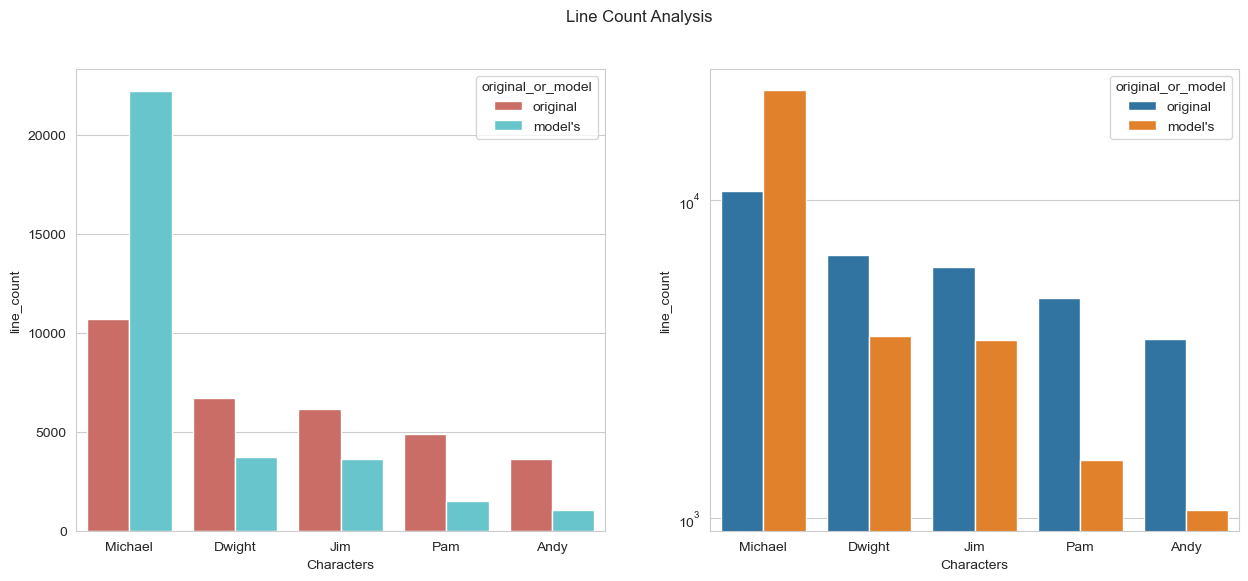

In [55]:

sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6),sharex=True)
fig.suptitle('Line Count Analysis')

sns.barplot(x='index', y='line_count', hue='original_or_model', data=df_last, palette='hls',ax=ax1)
sns.barplot(x='index', y='line_count', hue='original_or_model', data=df_last, palette='tab10',ax = ax2,log=True)
ax1.set_xlabel('Characters')
ax2.set_xlabel('Characters')




In [56]:

aa=int(input())
print(df2.speaker[aa])
print(dtc.x[aa])


7492
Dwight
michael referred me to a male strip club called banana slings. instead, i called the scholastic speakers of pennsylvania.


In [57]:
dtc.Predict(dtc.x[aa])

array(['Dwight'], dtype='<U7')

In [58]:
X3 = df2.line
X3
y3 = df2.speaker
y3
labels=y3.unique().tolist()
labels2 = {i[1]:i[0] for i in enumerate(labels)}
labels2
y_labels_all=df2.replace(labels2)["speaker"]
y_labels_all
i_label = {value:key for key,value in labels2.items()}
i_label

{0: 'Michael', 1: 'Jim', 2: 'Pam', 3: 'Dwight', 4: 'Andy'}

In [59]:
y_labels_all

0        0
1        1
2        0
3        1
4        0
        ..
54143    4
54147    1
54149    1
54165    1
54166    2
Name: speaker, Length: 32166, dtype: int64

In [60]:
lavector = CountVectorizer()
X4=lavector.fit_transform(X3)
X4.shape

(32166, 15274)

In [108]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X3, y_labels_all,stratify=y_labels_all ,test_size=0.2 )
#,stratify=y_labels_all

In [109]:
X_train,X_val,y_train,y_val =train_test_split(X_train_val,y_train_val ,stratify=y_train_val,test_size = 0.1)
#,stratify=y_train_val

In [110]:
Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)
Y_test = to_categorical(y_test)

In [111]:
lavector = CountVectorizer()

X_train =lavector.fit_transform(X_train)
X_val = lavector.transform(X_val)
X_test = lavector.transform(X_test)

X_train.shape

(23158, 13030)

In [112]:
X_val =X_val.astype('float32')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [113]:
X_train.shape

(23158, 13030)

In [114]:
X_test.shape

(6434, 13030)

In [115]:
X_val.shape

(2574, 13030)

In [116]:
i_label

{0: 'Michael', 1: 'Jim', 2: 'Pam', 3: 'Dwight', 4: 'Andy'}

In [117]:
model = models.Sequential()

model.add(layers.Dense(128, activation='sigmoid', input_shape = (X_train.shape[1],),bias_initializer='ones',kernel_initializer='random_uniform'))
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation='tanh' ,bias_initializer='zeros',kernel_initializer='random_uniform'))
model.add(BatchNormalization())
model.add(layers.Dense(len(i_label), activation='softmax',bias_initializer='zeros',kernel_initializer='random_uniform'))

In [118]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [119]:
Y_val


array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [120]:
history = model.fit(X_train,
                   Y_train,
                   epochs=100,
                   batch_size=1500,
                   validation_data=(X_val, Y_val))

Epoch 1/100


C:\Users\ahmet\anaconda3\envs\new_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_4/dense_12/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_4/dense_12/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_4/dense_12/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


16/16 [==============================] - 1s 28ms/step - loss: 1.6171 - accuracy: 0.2249 - val_loss: 1.6000 - val_accuracy: 0.3368
Epoch 2/100
16/16 [==============================] - 0s 20ms/step - loss: 1.5865 - accuracy: 0.2740 - val_loss: 1.5839 - val_accuracy: 0.3329
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 1.5656 - accuracy: 0.2943 - val_loss: 1.5779 - val_accuracy: 0.3329
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 1.5481 - accuracy: 0.3104 - val_loss: 1.5534 - val_accuracy: 0.3329
Epoch 5/100
16/16 [==============================] - 0s 25ms/step - loss: 1.5353 - accuracy: 0.3189 - val_loss: 1.5487 - val_accuracy: 0.3329
Epoch 6/100
16/16 [==============================] - 0s 25ms/step - loss: 1.5204 - accuracy: 0.3244 - val_loss: 1.5418 - val_accuracy: 0.3329
Epoch 7/100
16/16 [==============================] - 0s 25ms/step - loss: 1.5091 - accuracy: 0.3353 - val_loss: 1.5402 - val_accuracy: 0.3329
Epoch 8/100
16/16 

16/16 [==============================] - 0s 24ms/step - loss: 1.0665 - accuracy: 0.5554 - val_loss: 1.6127 - val_accuracy: 0.3901
Epoch 59/100
16/16 [==============================] - 0s 25ms/step - loss: 1.0664 - accuracy: 0.5596 - val_loss: 1.6212 - val_accuracy: 0.3998
Epoch 60/100
16/16 [==============================] - 0s 25ms/step - loss: 1.0581 - accuracy: 0.5589 - val_loss: 1.6287 - val_accuracy: 0.3990
Epoch 61/100
16/16 [==============================] - 0s 25ms/step - loss: 1.0511 - accuracy: 0.5646 - val_loss: 1.6453 - val_accuracy: 0.3970
Epoch 62/100
16/16 [==============================] - 0s 25ms/step - loss: 1.0525 - accuracy: 0.5665 - val_loss: 1.6462 - val_accuracy: 0.3854
Epoch 63/100
16/16 [==============================] - 0s 23ms/step - loss: 1.0377 - accuracy: 0.5711 - val_loss: 1.6601 - val_accuracy: 0.3916
Epoch 64/100
16/16 [==============================] - 0s 25ms/step - loss: 1.0382 - accuracy: 0.5720 - val_loss: 1.6696 - val_accuracy: 0.3943
Epoch 65/100

Minimum Validation Loss: 1.4411
0.6249244213104248


<AxesSubplot:>

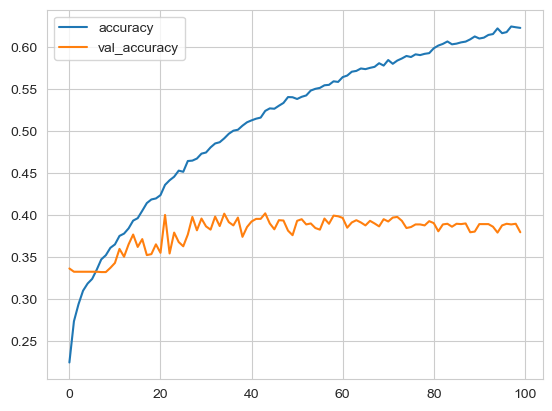

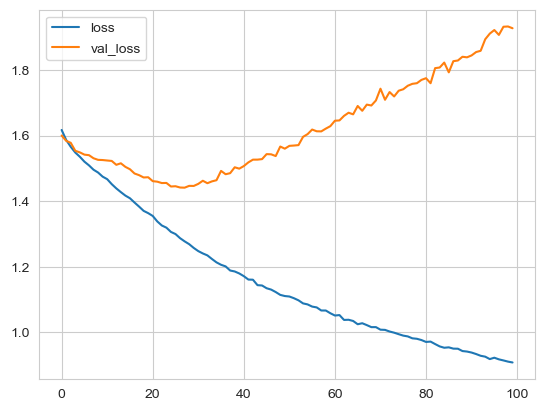

In [121]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
print(history_df["accuracy"].max())
history_df.loc[:, ['loss', 'val_loss']].plot()

In [122]:
model.evaluate(X_test,Y_test)

202/202 [==============================] - 0s 1ms/step - loss: 1.8463 - accuracy: 0.3743


[1.8463292121887207, 0.374261736869812]

In [123]:
Y_test

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [132]:
a = 28221
bım=df2.line[a]


In [133]:
bım2=lavector.transform([bım])

In [134]:
model.predict(bım2).argmax()

1/1 [==============================] - 0s 14ms/step


0

In [135]:
i_label


{0: 'Michael', 1: 'Jim', 2: 'Pam', 3: 'Dwight', 4: 'Andy'}

In [136]:
df2.line[a]

' yeah?'

In [137]:
df2.speaker[a]

'Michael'

In [138]:
bıma=model.predict(X_test).argmax(axis=1)

202/202 [==============================] - 0s 928us/step


In [131]:
sum(y_test ==  bıma)/y_test.size

0.37426173453528133